In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc
import numpy.random as rn
import networkx as nx
import my_networkx as my_nx

mpl.rcParams.update({'font.size': 18})


In [34]:
A = np.array([[0, 1, 0, 0, 0, 0],[1, 0, 1, 0, 1, 0],[0, 1, 0, 1, 0, 0],[0, 0, 1, 0, 1, 0],[0, 1, 0, 1, 0, 1],[0, 0, 0, 0, 1, 0]])
print(A)

[[0 1 0 0 0 0]
 [1 0 1 0 1 0]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 1 0 1 0 1]
 [0 0 0 0 1 0]]


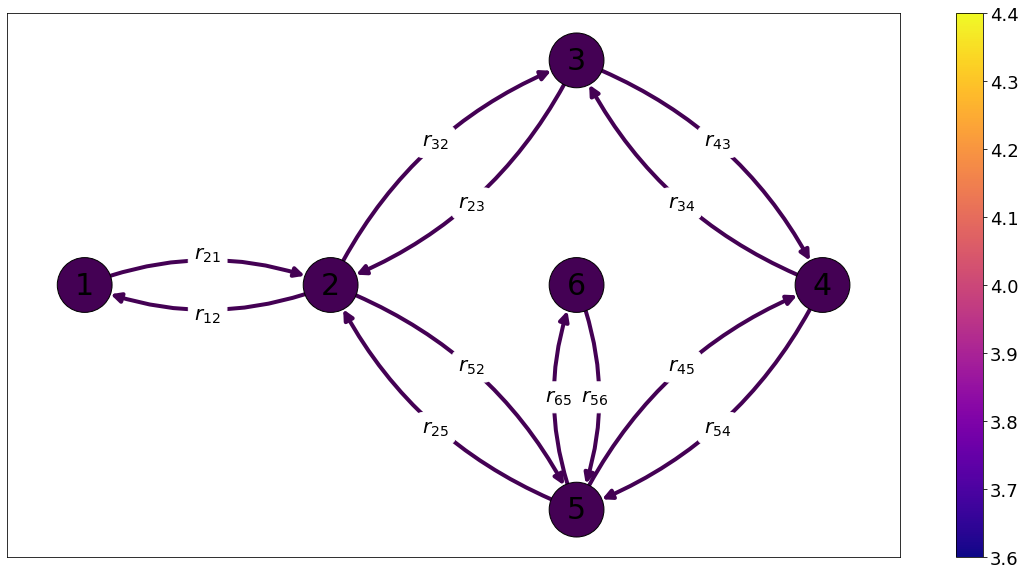

In [35]:
def plot_network(A, we=np.ones_like(A), position={1:(0,0),2:(1,0),3:(2,1),4:(3,0),5:(2,-1),6:(2,0)}, name="figures/Example_Calmodulin_1.pdf", node_color=np.ones(len(A))):
    
    G = nx.DiGraph() 
    edges = []
    k = 0
    color = []
    for i in range(len(A[:,0])): 
        for j in range(len(A[:,0])): 
            if A[i, j] == 1: 
                #G.add_edge(i,j)
                edges.append((i+1, j+1, {"weight":we[i,j], "w":r"$r_{%d%d}$" % (i+1, j+1)}))
                color.append(we[i,j])

        G.add_node(i+1)

    G.add_edges_from(edges)

    weights = [ 4 * G[u][v]['weight'] for u,v in G.edges]

    fixed_positions = position #dict with two of the positions set
    fixed_nodes = fixed_positions.keys()
    pos = nx.spring_layout(G, pos=fixed_positions, fixed=fixed_nodes)

    cmap = plt.cm.plasma

    fig, ax = plt.subplots(figsize=(20, 10))
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=3000, edgecolors="k", node_color=node_color)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=30)

    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
    straight_edges = list(set(G.edges()) - set(curved_edges))
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=straight_edges, arrowstyle="<|-", width=5, node_size=3000)
    arc_rad = 0.2
    edges_plot = nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}', arrowstyle="<|-", width=weights, edge_color=weights, arrowsize=20, node_size=3000)

    pc = mpl.collections.PatchCollection(edges_plot, cmap=cmap)
    pc.set_array(weights)

    edge_weights = nx.get_edge_attributes(G,'w')
    curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
    straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
    my_nx.my_draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad, font_size=20)
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=straight_edge_labels,rotate=False)
    plt.colorbar(pc, ax=ax)
    plt.savefig(name, dpi=500, bbox_inches="tight")

plot_network(A)

In [36]:
def printMatrix(s):
    
    for i in range(len(s)):
        for j in range(len(s[0])):
            print("%f   " % (s[i][j]), end="")
        print("\n") 

In [39]:
def Matrices(energies, A):
    N = len(energies)
    peq = np.exp(-energies)
    Z = np.sum(peq)
    peq = peq/Z
    # Probability matrix
    Pmatrix = np.zeros((N, N))
    for i in range(N):
        Pmatrix[i, i] = np.sqrt(peq[i])

    #Master operator DB
    L = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if A[i, j] == 1:
                L[i, j] = np.exp((energies[j]-energies[i])/2)
    for i in range(N):
        L[i, i] = - np.sum(L[:, i])
    # Symmetrised Master op DB
    Ls = np.matmul(np.linalg.inv(Pmatrix), np.matmul(L, Pmatrix))

    return Pmatrix, L, Ls, peq




In [40]:
energies = rn.exponential(1, size=(6))
print(energies)

[0.99249565 0.47237541 0.47177223 3.26031543 3.19907161 0.80001835]


In [41]:
peq = np.exp(-energies)
Z = np.sum(peq)
peq = peq/Z

In [42]:
N = len(peq)
Pmatrix = np.zeros((N, N))
for i in range(N):
    Pmatrix[i, i] = np.sqrt(peq[i])

printMatrix(Pmatrix)

0.415538   0.000000   0.000000   0.000000   0.000000   0.000000   

0.000000   0.538956   0.000000   0.000000   0.000000   0.000000   

0.000000   0.000000   0.539118   0.000000   0.000000   0.000000   

0.000000   0.000000   0.000000   0.133709   0.000000   0.000000   

0.000000   0.000000   0.000000   0.000000   0.137866   0.000000   

0.000000   0.000000   0.000000   0.000000   0.000000   0.457516   



In [43]:
L = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if A[i, j] == 1:
            L[i, j] = np.exp(energies[j])
    L[i, i] = - np.sum(L[i, :])

Ls = np.matmul(np.linalg.inv(Pmatrix), np.matmul(L, Pmatrix))
print(Ls)


ew, ev = np.linalg.eigh(Ls)
print("\n eigenvalues")
print(ew)

D = np.matmul(ev.T, np.matmul(Ls, ev))
print(D)



[[ -1.60379936   2.0801407    0.           0.           0.
    0.        ]
 [  2.0801407  -28.81055648   1.60331574   0.           6.26966868
    0.        ]
 [  0.           1.60331574 -27.66155449   6.46267829   0.
    0.        ]
 [  0.           0.           6.46267829 -26.11259724  25.27191037
    0.        ]
 [  0.           6.26966868   0.          25.27191037 -29.88713627
    7.38569471]
 [  0.           0.           0.           0.           7.38569471
  -24.50976497]]

 eigenvalues
[-5.58508132e+01 -2.88348101e+01 -2.85525100e+01 -2.38260487e+01
 -1.52122674e+00 -1.24256955e-14]
[[-5.58508132e+01 -3.10862447e-15  3.33066907e-15 -3.99680289e-15
  -2.12330153e-15  1.40662242e-14]
 [-8.88178420e-16 -2.88348101e+01  6.66133815e-16  1.77635684e-15
   1.44155521e-15 -4.80565012e-15]
 [ 5.32907052e-15 -8.88178420e-16 -2.85525100e+01 -8.88178420e-16
   1.73125403e-15 -7.91329310e-15]
 [-1.77635684e-15  8.88178420e-16 -3.55271368e-15 -2.38260487e+01
  -4.57966998e-16  2.84195600e-15]


In [44]:
scale = 0.05
As = scale*np.array([[1/scale, 0, 0, 0, 0, 0], [0, 1/scale, 1, 0, -1, 0], [0, -1, 1/scale, 1, 0, 0], [0, 0, -1, 1/scale, 1, 0], [0, 1, 0, -1, 1/scale, 0], [0, 0, 0, 0, 0, 1/scale]])
print(As)

[[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.05  0.   -0.05  0.  ]
 [ 0.   -0.05  1.    0.05  0.    0.  ]
 [ 0.    0.   -0.05  1.    0.05  0.  ]
 [ 0.    0.05  0.   -0.05  1.    0.  ]
 [ 0.    0.    0.    0.    0.    1.  ]]


In [45]:
Ltot = -sqrtLs.dot(As.dot(sqrtLs))
print(Ltot)

ValueError: shapes (6,6) and (3,3) not aligned: 6 (dim 1) != 3 (dim 0)

In [46]:
wow = np.matmul(Pmatrix, np.matmul(Ltot, np.linalg.inv(Pmatrix)))

for i in range(6):
    for j in range(6):
        if i != j and wow[i, j] < 0:
            wow[i, j] = 0
    #print(wow[i, :])
    print(np.sum(wow[i:]))

print(wow)

NameError: name 'Ltot' is not defined

In [47]:
wow2 = np.matmul(wow, np.matmul(Pmatrix, Pmatrix))

plot_network(A, wow2, name="figures/Example_Calmodulin_2.pdf", peq)

SyntaxError: positional argument follows keyword argument (<ipython-input-47-4e4385daa596>, line 3)

## Three State System

In [48]:
energies = rn.exponential(1, size=(3))
A = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])

def Matrices(energies, A):
    N = len(energies)
    peq = np.exp(-energies)
    Z = np.sum(peq)
    peq = peq/Z
    # Probability matrix
    Pmatrix = np.zeros((N, N))
    for i in range(N):
        Pmatrix[i, i] = np.sqrt(peq[i])

    #Master operator DB
    L = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if A[i, j] == 1:
                L[i, j] = np.exp((energies[j]-energies[i])/2)
    for i in range(N):
        L[i, i] = - np.sum(L[:, i])
    # Symmetrised Master op DB
    Ls = np.matmul(np.linalg.inv(Pmatrix), np.matmul(L, Pmatrix))

    return Pmatrix, L, Ls, peq



Peq, L, Ls, peq = Matrices(energies=energies, A=A)


a = L[0, 1]
b = L[0, 2]
c = L[1, 0]
d = L[1, 2]
e = L[2, 0]
f = L[2, 1]



EWs, EVs = np.linalg.eigh(Ls)

print(np.linalg.eigh(Ls)[0])
print(np.linalg.eig(L)[0])

print(np.linalg.eig(L)[1])


printMatrix(Ls)
printMatrix(L)

print(peq)


E = np.linalg.eig(L)[0]

x = np.argmin(np.abs(E))


v = np.linalg.eig(L)[1]
v = v[:, x]
print(v, x)
print(v / peq)

[-3.53792269e+00 -2.80474459e+00  1.76920407e-16]
[-4.44089210e-16 -2.80474459e+00 -3.53792269e+00]
[[-0.42800638 -0.54361061 -0.60102669]
 [-0.83911635  0.79940897 -0.17810465]
 [-0.3356997  -0.25579836  0.77913134]]
-2.285813   1.000000   1.000000   

1.000000   -1.346696   1.000000   

1.000000   1.000000   -2.710158   

-2.285813   0.714190   1.129145   

1.400187   -1.346696   1.581014   

0.885626   0.632506   -2.710158   

[0.26703294 0.52352422 0.20944285]
[-0.42800638 -0.83911635 -0.3356997 ] 0
[-1.60282243 -1.60282243 -1.60282243]


In [49]:
D = np.diag(EWs)


printMatrix(D)

Ds = np.matmul(EVs.T, np.matmul(Ls, EVs))

printMatrix(Ds)


print(Ds)

-3.537923   0.000000   0.000000   

0.000000   -2.804745   0.000000   

0.000000   0.000000   0.000000   

-3.537923   -0.000000   0.000000   

-0.000000   -2.804745   -0.000000   

-0.000000   0.000000   -0.000000   

[[-3.53792269e+00 -3.33066907e-16  1.68889409e-16]
 [-6.66133815e-16 -2.80474459e+00 -8.90809290e-19]
 [-2.22044605e-16  5.55111512e-17 -1.81948707e-16]]


In [50]:
print(EWs, -EWs)
sqrtLs = np.matmul(EVs, np.matmul(np.diag(np.sqrt(np.abs(EWs))), EVs.T)) 
printMatrix(sqrtLs)

[-3.53792269e+00 -2.80474459e+00  1.76920407e-16] [ 3.53792269e+00  2.80474459e+00 -1.76920407e-16]
1.292220   -0.612486   -0.490755   

-0.612486   0.800869   -0.574600   

-0.490755   -0.574600   1.462584   



In [51]:
scale = 0.1
A = scale * np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]])


printMatrix(-np.matmul(sqrtLs, np.matmul(A, sqrtLs)))

-0.000000   -0.065976   0.104309   

0.065976   -0.000000   -0.074497   

-0.104309   0.074497   -0.000000   



In [52]:
printMatrix(-np.matmul(sqrtLs, np.matmul(np.identity(3) + A, sqrtLs)))

print(np.identity(3))

-2.285813   0.934024   1.104309   

1.065976   -1.346696   0.925503   

0.895691   1.074497   -2.710158   

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [53]:
positions = {1:(1, 0), 2:()}

In [54]:
Lneq = -np.matmul(sqrtLs, np.matmul(np.identity(3) + A, sqrtLs))#
printMatrix(Lneq)

-2.285813   0.934024   1.104309   

1.065976   -1.346696   0.925503   

0.895691   1.074497   -2.710158   



In [55]:
print(np.linalg.eig(Lneq)[0])
print(np.linalg.eig(Lneq)[1])
print(Peq)

[ 0.         -2.83428085 -3.50838643]
[[-0.5167523  -0.74672518 -0.67868309]
 [-0.72354973  0.64238558  0.02035554]
 [-0.45764926 -0.1724595   0.73414911]]
[[0.5167523  0.         0.        ]
 [0.         0.72354973 0.        ]
 [0.         0.         0.45764926]]


In [56]:
print(np.matmul(Lneq, np.array([0.53117816, 0.53012983, 0.66091764])))
print(peq)
print(np.matmul(Lneq, peq))

[ 0.01083746  0.46398103 -0.74579741]
[0.26703294 0.52352422 0.20944285]
[ 0.10988649 -0.22653719  0.23408062]


In [57]:
Lneqneq = np.matmul(Peq, np.matmul(Lneq, np.linalg.inv(Peq)))

printMatrix(Lneqneq)
print("##################")

c, c1 = np.linalg.eig(Lneqneq)
c2, c3 = np.linalg.eig(L)


printMatrix(c1)

print(c)

printMatrix(c3)

print(c2)

print(peq)

-2.285813   0.667071   1.246925   

1.492566   -1.346696   1.463234   

0.793247   0.679625   -2.710158   

##################
-0.428006   -0.633374   -0.721775   

-0.839116   0.762924   0.030311   

-0.335700   -0.129550   0.691464   

[ 0.         -2.83428085 -3.50838643]
-0.428006   -0.543611   -0.601027   

-0.839116   0.799409   -0.178105   

-0.335700   -0.255798   0.779131   

[-4.44089210e-16 -2.80474459e+00 -3.53792269e+00]
[0.26703294 0.52352422 0.20944285]


In [58]:
x = np.argmin(np.abs(c))

v = c1[:, x]

print(v /peq)

[-1.60282242 -1.60282243 -1.60282243]


[0.26703294 0.52352422 0.20944285]


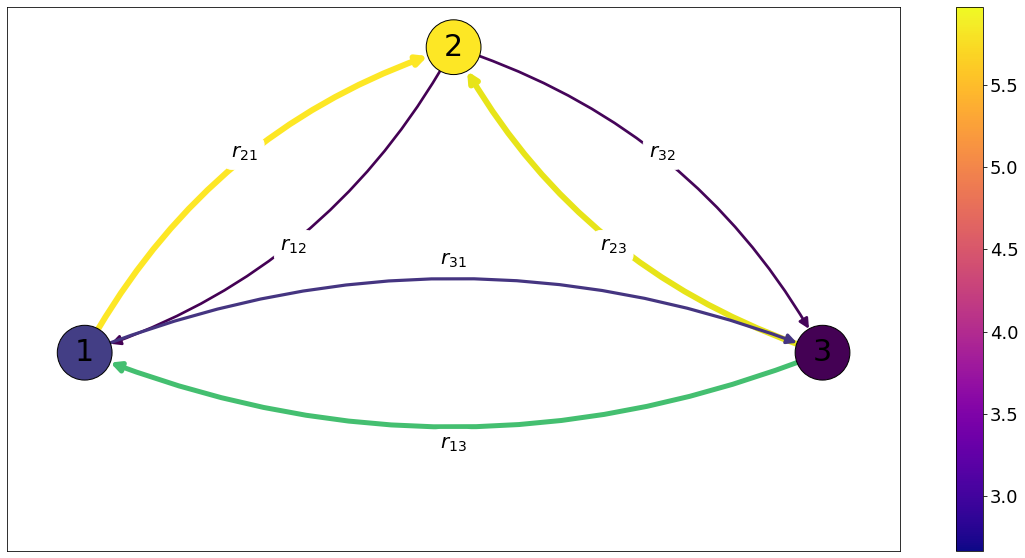

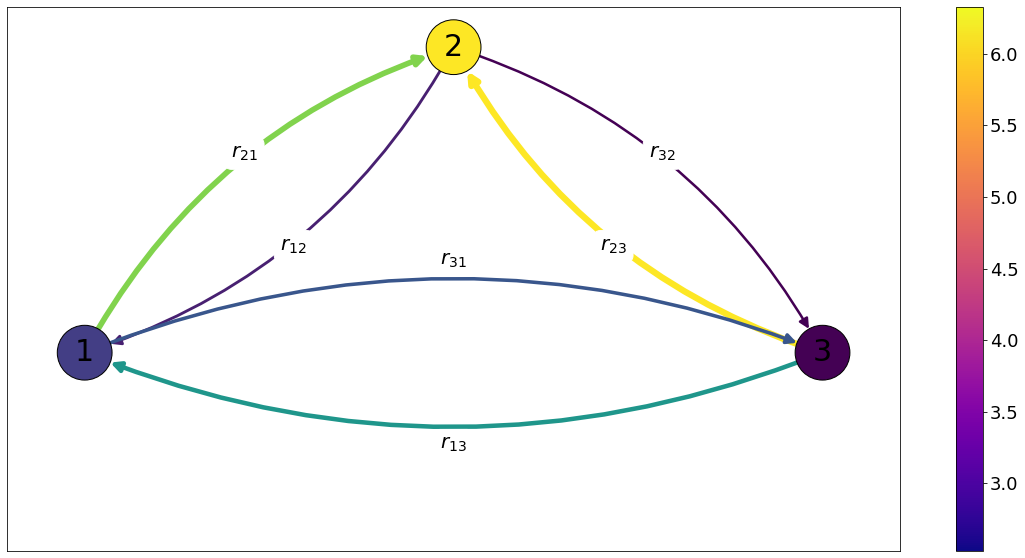

In [62]:
pos = {1:(0, 0), 2:(1, np.sqrt(2)), 3:(2, 0)}

adj = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])


plot_network(adj, Lneqneq, pos, name="figures/3state", node_color=peq)
plot_network(adj, L, pos, name="figures/3state_eq", node_color=peq)

print(peq)